In [ ]:
!pip install wandb


In [2]:
!wandb login --relogin


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import scipy.io
import torch.nn as nn
import torch.optim as optim
import os
import torchvision.models as models
import numpy as np
from sklearn.manifold import TSNE
import torchvision.transforms as T
from PIL import Image
import torchvision.models.segmentation as segm
from torchvision import transforms
import wandb

# 1) 
  1-A

In [10]:
mat = scipy.io.loadmat('/content/drive/MyDrive/cvAssn/train_32x32.mat')
img = torch.from_numpy(mat['X']).permute(3,2,0,1).to(torch.float32)
label = torch.from_numpy(mat['y']).to(torch.float32)
label = torch.squeeze(label, dim=1)


train_percent = int(0.7 * len(img))
train_img,rest_img = (img[-train_percent:,:,:,:],img[:-train_percent,:,:,:])
train_label, rest_label = (label[-train_percent:],label[:-train_percent])

val_percent = int(0.66 * len(rest_img))
val_img, test_img = (rest_img[-val_percent:,:,:,:],rest_img[:-val_percent,:,:,:])
val_label, test_label = (rest_label[-val_percent:],rest_label[:-val_percent])

# 1) 
1-B

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, data, label, transform=None, transform_label=None):
        self.transform = transform
        self.transform_label = transform_label
        self.img = data
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label


training_data = CustomImageDataset(train_img,train_label)
val_data = CustomImageDataset(val_img,val_label)
test_data = CustomImageDataset(test_img,test_label)

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# 1) 
1-C

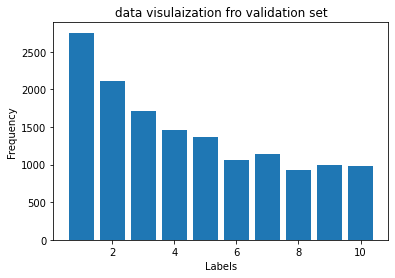

In [ ]:
labels, labels_count = torch.unique(val_label, return_counts=True)

# Plotting the bar graph
plt.bar(labels, labels_count)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("data visulaization fro validation set")
plt.show()

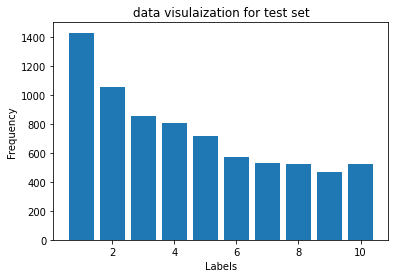

In [ ]:
labels, labels_count = torch.unique(test_label, return_counts=True)

# Plotting the bar graph
plt.bar(labels, labels_count)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("data visulaization for test set")
plt.show()

# 1.)
  2-a

In [12]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.fc = nn.Linear(in_features=64 * 32 * 32, out_features=11)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        
        x = self.fc(x)
        return x
cnn = CNN()

2-b

In [13]:

wandb.init(
    # set the wandb project where this run will be logged
    project="assn1",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "custom",
    "dataset": "SVHN",
    "epochs": 2,
    }
)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    accuracy = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.to(torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = cnn(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        accuracy += loss.item() 
        running_loss += loss.item()
        if i % 50 == 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

    wandb.log({"epoch": epoch+1, "accuracy": accuracy/len(train_dataloader)})

print('Finished Training')

[1,     2] loss: 239.090
[1,    52] loss: 219163969.801
[1,   102] loss: 389178745.760
[1,   152] loss: 346647799.755
[1,   202] loss: 180902805.700
[1,   252] loss: 194771143.305
[1,   302] loss: 166244252.500
[1,   352] loss: 124086671.020
[1,   402] loss: 140037313.545
[1,   452] loss: 122646323.858
[1,   502] loss: 136042143.190
[1,   552] loss: 103323906.610
[1,   602] loss: 87657117.192
[1,   652] loss: 85459644.194
[1,   702] loss: 168871539.760
[1,   752] loss: 174461430.740
[1,   802] loss: 64339919.795
[1,   852] loss: 44822805.705
[1,   902] loss: 30266252.150
[1,   952] loss: 31333247.306
[1,  1002] loss: 27954017.942
[1,  1052] loss: 25513347.517
[1,  1102] loss: 21100752.485
[1,  1152] loss: 45093098.974
[1,  1202] loss: 21117045.300
[1,  1252] loss: 14695000.425
[1,  1302] loss: 16104090.757
[1,  1352] loss: 15392921.535
[1,  1402] loss: 22495528.697
[1,  1452] loss: 10804293.117
[1,  1502] loss: 8203499.883
[1,  1552] loss: 7728203.937
[1,  1602] loss: 6647626.081
[2,  

In [15]:
wandb.watch(cnn)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    accuracy = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.to(torch.long)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = cnn(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print("epoch : ",(epoch+1) ,"training loss : ",(running_loss/len(train_dataloader)))

    cnn.eval()

    # Initialize counters
    correct = 0
    total = 0
    val_loss = 0
    # Turn off gradient computations
    with torch.no_grad():
        # Iterate over the test dataset
        for inputs, labels in val_dataloader:
            # Forward pass
            outputs = cnn(inputs)
            labels = labels.to(torch.long)
            
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Count the number of correct predictions
            correct += (predicted == labels).sum().item()
            # Count the total number of labels
            total += labels.size(0)

    # Calculate the accuracy
    accuracy = 100 * correct / total
    print("epoch : ",(epoch+1) ," validation loss : ",(val_loss/len(val_dataloader))," accuracy : ",accuracy)

    wandb.log({"epoch": epoch+1, "accuracy": accuracy, "training loss": running_loss/len(train_dataloader), "validation loss": val_loss/len(val_dataloader)})




epoch :  1 training loss :  2.278590226649346
epoch :  1  validation loss :  2.2740130261702682  accuracy :  18.979662185453293
epoch :  2 training loss :  2.274511585069015
epoch :  2  validation loss :  2.2374969269210547  accuracy :  18.979662185453293
epoch :  3 training loss :  2.2617053192850207
epoch :  3  validation loss :  2.2430199505474073  accuracy :  18.979662185453293
epoch :  4 training loss :  2.257557700815159
epoch :  4  validation loss :  2.2640955303734094  accuracy :  18.979662185453293
epoch :  5 training loss :  2.2497701677618664
epoch :  5  validation loss :  2.2392149223630122  accuracy :  18.979662185453293


In [6]:
path = '/content/drive/MyDrive/cvAssn/cnn.pt'
torch.save(cnn.state_dict(), path)

2-c

In [7]:
path = '/content/drive/MyDrive/cvAssn/cnn.pt'
cnn = CNN()
cnn.load_state_dict(torch.load(path))

<All keys matched successfully>

In [25]:
from sklearn.metrics import f1_score, confusion_matrix

acc = 0
true = []
pred = []

cnn.eval()

for i, data in enumerate(test_dataloader, 0):
        
        inputs, labels = data
        labels = labels.to(torch.long)
        outputs = cnn(inputs)
        outputs = nn.functional.softmax(outputs,dim=1)
        outputs = torch.argmax(outputs, dim=1)

        acc += (outputs==labels).sum().item()
        
        true.extend(labels.numpy())
        pred.extend(outputs.numpy())


cm = confusion_matrix(true, pred)

f1 = f1_score(true, pred, average='macro')

print("Accuracy",acc/len(test_img))
print("confusion matrix", cm)
print("f1-score",f1)
wandb.log({"Accuracy": acc/len(test_img), "confusion matrix": cm, "f1-score":f1})

Accuracy: 19.14%


# 1)
3a.)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models


# Load the ResNet-18 model pre-trained on ImageNet
model = models.resnet18(pretrained=True)

# Freeze all the layers in the model
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes in the CIFAR-10 dataset
num_classes = 11
# model.
model.fc = nn.Linear(512, num_classes)



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(5):
    running_loss = 0.0
    accuracy = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.to(torch.long)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        accuracy += loss.item()
        if i % 50 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
      
    wandb.log({"epoch": epoch+1, "accuracy": accuracy/len(train_dataloader)})

print('Finished Training')


[1,     2] loss: 0.109
[1,    52] loss: 2.387
[1,   102] loss: 2.243
[1,   152] loss: 2.182
[1,   202] loss: 2.175
[1,   252] loss: 2.132
[1,   302] loss: 2.089
[1,   352] loss: 2.091
[1,   402] loss: 2.056
[1,   452] loss: 2.094
[1,   502] loss: 2.086
[1,   552] loss: 2.053
[1,   602] loss: 2.068
[1,   652] loss: 2.029
[1,   702] loss: 2.026
[1,   752] loss: 2.055
[1,   802] loss: 2.057
[1,   852] loss: 2.004
[1,   902] loss: 2.037
[1,   952] loss: 2.032
[1,  1002] loss: 2.003
[1,  1052] loss: 2.005
[1,  1102] loss: 2.022
[1,  1152] loss: 1.981
[1,  1202] loss: 2.029
[1,  1252] loss: 2.031
[1,  1302] loss: 1.981
[1,  1352] loss: 2.025
[1,  1402] loss: 2.012
[1,  1452] loss: 2.011
[1,  1502] loss: 1.991
[1,  1552] loss: 1.992
[1,  1602] loss: 1.974
[2,     2] loss: 0.076
[2,    52] loss: 1.969
[2,   102] loss: 1.972
[2,   152] loss: 1.954
[2,   202] loss: 1.994
[2,   252] loss: 1.940
[2,   302] loss: 2.014
[2,   352] loss: 1.973
[2,   402] loss: 1.982
[2,   452] loss: 1.994
[2,   502] 

In [ ]:
# saving the model
save_dir = "/content/drive/MyDrive/cvAssn/models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'resnet_model.pth')
torch.save(model, save_path)

3b.)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

acc = 0
true = []
pred = []

model.eval()

for i, data in enumerate(test_dataloader, 0):
        
        inputs, labels = data
        labels = labels.to(torch.long)
        outputs = model(inputs)
        outputs = nn.functional.softmax(outputs,dim=1)
        outputs = torch.argmax(outputs, dim=1)

        acc += (outputs==labels).sum().item()
        
        true.extend(labels.numpy())
        pred.extend(outputs.numpy())


cm = confusion_matrix(true, pred)

f1 = f1_score(true, pred, average='macro')

print("Accuracy",acc/len(test_img))
print("confusion matrix", cm)
print("f1-score",f1)

wandb.log({"Accuracy":acc/len(test_img), "Confusion matrix":cm, "F1- Score":f1})

3-c)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


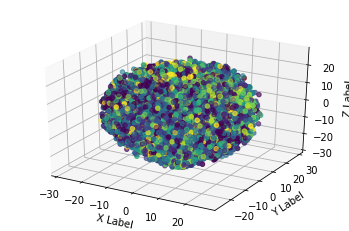

In [ ]:
# loading the model
resnet_model = torch.load('/content/drive/MyDrive/cvAssn/models/resnet_model.pth')

#making the last layer identity layer
resnet_model.fc = nn.Identity()

features = []
labels = []
with torch.no_grad():
    for images, batch_labels in train_dataloader:
        outputs = resnet_model(images)
        features.append(outputs.cpu().numpy())
        labels.append(batch_labels)
features = np.concatenate(features)
labels = np.concatenate(labels)

# Use t-SNE to visualize the feature vectors in 3-D space
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
features_tsne = tsne.fit_transform(features)

# Plot the t-SNE visualization in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c=labels, cmap='viridis')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


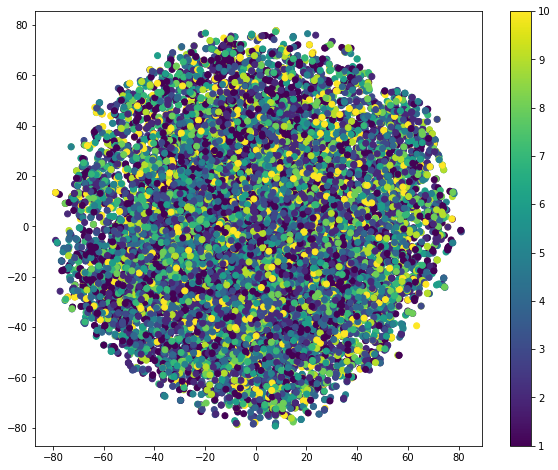

In [ ]:
# Extract feature vectors from the validation set using the ResNet-18 model
features = []
labels = []
with torch.no_grad():
    for images, batch_labels in val_dataloader:
        outputs = resnet_model(images)
        features.append(outputs.cpu().numpy())
        labels.append(batch_labels)
features = np.concatenate(features)
labels = np.concatenate(labels)

# Use t-SNE to visualize the feature vectors in 2-D space
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
features_tsne = tsne.fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.show()


4-a.)

In [ ]:
# sample_data = CustomImageDataset(s1,l1)

transform1 = T.Compose([
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=.5, hue=.3),
    T.RandomPerspective(distortion_scale=0.6, p=1.0),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    
])

augmented_data = CustomImageDataset(train_img, train_label, transform1)
augmented_dataloader = DataLoader(augmented_data, batch_size=32)

4-b.)

In [ ]:

# Load the ResNet-18 model pre-trained on ImageNet
model = models.resnet18(pretrained=True)

# Freeze all the layers in the model
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes in the CIFAR-10 dataset
num_classes = 11
model.fc = nn.Linear(512, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(5):
    running_loss = 0.0
    
    for i, data in enumerate(augmented_dataloader, 0):
        # get the inputs
        inputs, labels = data
        labels = labels.to(torch.long)
        
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')


[1,     2] loss: 0.113
[1,    52] loss: 2.467
[1,   102] loss: 2.405
[1,   152] loss: 2.404
[1,   202] loss: 2.403
[1,   252] loss: 2.400
[1,   302] loss: 2.397
[1,   352] loss: 2.344
[1,   402] loss: 2.332
[1,   452] loss: 2.372
[1,   502] loss: 2.345
[1,   552] loss: 2.345
[1,   602] loss: 2.327
[1,   652] loss: 2.360
[1,   702] loss: 2.354
[1,   752] loss: 2.350
[1,   802] loss: 2.357
[1,   852] loss: 2.354
[1,   902] loss: 2.304
[1,   952] loss: 2.350
[1,  1002] loss: 2.350
[1,  1052] loss: 2.340
[1,  1102] loss: 2.293
[1,  1152] loss: 2.318
[1,  1202] loss: 2.332
[1,  1252] loss: 2.320
[1,  1302] loss: 2.325
[1,  1352] loss: 2.329
[1,  1402] loss: 2.338
[1,  1452] loss: 2.324
[1,  1502] loss: 2.318
[1,  1552] loss: 2.313
[1,  1602] loss: 2.358
[2,     2] loss: 0.092
[2,    52] loss: 2.336
[2,   102] loss: 2.321
[2,   152] loss: 2.334
[2,   202] loss: 2.317
[2,   252] loss: 2.346
[2,   302] loss: 2.347
[2,   352] loss: 2.307
[2,   402] loss: 2.338
[2,   452] loss: 2.342
[2,   502] 

4)-c

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

acc = 0
true = []
pred = []

model.eval()

for i, data in enumerate(test_dataloader, 0):
        
        inputs, labels = data
        labels = labels.to(torch.long)
        outputs = model(inputs)
        outputs = nn.functional.softmax(outputs,dim=1)
        outputs = torch.argmax(outputs, dim=1)

        acc += (outputs==labels).sum().item()
        
        true.extend(labels.numpy())
        pred.extend(outputs.numpy())

f1 = f1_score(true, pred, average='macro')

print("Accuracy",acc/len(test_img))
print("f1-score",f1)

wandb.log({"Accuracy":acc/len(test_img), "F1-Score":f1})

6

In [ ]:
we can see that the accuracy is increasing

# 2
1-a)


In [4]:

# Set the path to the directory containing the images
image_dir = '/content/drive/MyDrive/cvAssn/VOC Segmentation Dataset/images'
mask_dir = '/content/drive/MyDrive/cvAssn/VOC Segmentation Dataset/masks'

images = []
masks = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    name, extension = os.path.splitext(filename)
    
    image = Image.open(os.path.join(image_dir, name+'.jpg'))
    images.append(image) 

    mask = Image.open(os.path.join(mask_dir, name+'.png'))
    masks.append(mask)

In [5]:
train_percent = int(0.7 * len(images))
train_img,rest_img = (images[-train_percent:],images[:-train_percent])
train_mask, rest_mask = (masks[-train_percent:],masks[:-train_percent])

val_percent = int(0.66 * len(rest_img))
val_img, test_img = (rest_img[-val_percent:],rest_img[:-val_percent])
val_mask, test_mask = (rest_mask[-val_percent:],rest_mask[:-val_percent])

1-b)

In [6]:
transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
])

class CustomImageDataset(Dataset):
    def __init__(self, data, label, transform=None, transform_label=None):
        self.transform = transform
        self.transform_label = transform_label
        self.img = data
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.label[idx]
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label


training_data = CustomImageDataset(train_img,train_mask,transform,transform)
val_data = CustomImageDataset(val_img,val_mask,transform,transform)
test_data = CustomImageDataset(test_img,test_mask,transform,transform)

batch = 16
train_dataloader = DataLoader(training_data, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch, shuffle=True)

2-a.)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models.segmentation as segm
from torchvision import transforms

import wandb
import random

wandb.init(
    # set the wandb project where this run will be logged
    project="assn1",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "resnet",
    "dataset": "VOC12",
    "epochs": 2,
    }
)

# Load pre-trained ResNet50 model
model = segm.fcn_resnet50(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


for epoch in range(2):
    total_acc = 0
    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        images, labels = data
        # Forward pass
        outputs = model(images)['out']

        masks = torch.nn.functional.softmax(outputs, dim=1)
        val,ind = torch.max(masks, dim= 1)

        acc = ((val[0].clone().to(torch.int64)==labels[0]).sum().item())
        acc /= (250*250*batch)

        labels = torch.squeeze(labels)
        labels = labels.to(torch.long)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        total_acc += acc
        running_loss += loss.item() 
        if i % 50 == 1:    # Print every 50 mini-batches
            print('epoch',epoch + 1,' index ', i + 1, 'running loss' ,running_loss / ((i+1)*batch))
            # running_loss = 0.0

    print("epoch : ",(epoch+1) ," acc : ",(total_acc/len(train_dataloader))," loss : ",(running_loss/len(train_dataloader)))
    

    model.eval()

    val_loss=0
    with torch.no_grad():
      for i,(image,labels) in enumerate(val_dataloader):
        
        out= model(image)['out']

        labels = torch.squeeze(labels)
        labels = labels.to(torch.long)

        loss = criterion(out,labels)
        val_loss += loss.item()

        print("epoch: ",epoch+1," i :",i+1,"loss_item: ", loss.item())

    print("epoch : ",(epoch+1) ," val_loss : ",(val_loss/len(val_dataloader)))
    wandb.log({"epoch": (epoch+1), "acc": (total_acc/len(train_dataloader)), "training loss": (running_loss/len(train_dataloader)), "validation loss": (val_loss/len(val_dataloader))})

wandb.finish()

acc,▁
epoch,▁
training loss,▁
validation loss,▁
acc,0.04336
epoch,1
training loss,0.23473
validation loss,0.22428


KeyboardInterrupt: ignored

In [ ]:
path = '/content/drive/MyDrive/cvAssn/wandb_fcn_resnet.pt'
torch.save(model, path)


3-a.)

In [ ]:
transform1 = T.Compose([
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=.5, hue=.3),
    T.RandomPerspective(distortion_scale=0.6, p=1.0),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),    
])

torch.int64


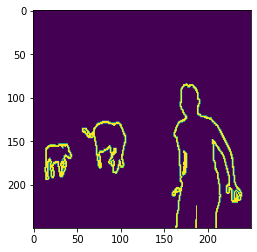

In [144]:
plt.imshow(labels[0])
print(labels.dtype)

In [4]:
np.unique(val[0].detach().numpy())

NameError: ignored

In [22]:
cor = ((val[0].clone().to(torch.int64)==labels[0]).sum().item())
cor/(250*250)

0.963904

In [104]:
outputs.shape

torch.Size([2, 21, 250, 250])

torch.Size([2, 21, 250, 250]) torch.Size([21, 250])


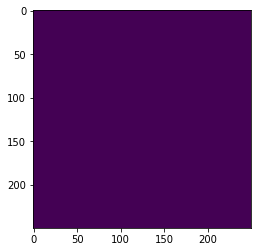

In [121]:
ot = torch.argmax(predict[0],dim=1)
print(predict.shape,ot.shape)
plt.imshow(predict[0,2].detach().numpy())

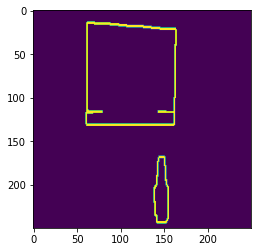

In [109]:
obj = labels[1].detach().numpy()
plt.imshow(obj)

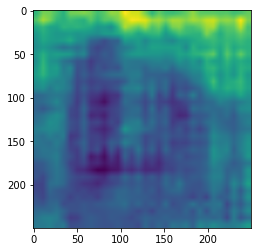

In [83]:
obj = outputs[1,0].detach().numpy()
plt.imshow(obj)

In [ ]:
path = '/content/drive/MyDrive/cvAssn/fcn_resnet.pt'
torch.save(model, path)


In [ ]:
path = '/content/drive/MyDrive/cvAssn/fcn_resnet.pt'
# Load the model
loaded_model = torch.load(path)